# 03 - Running on the IBMQ cloud simulators, QVM or QPU

We have seen examples of running QAOA on mostly simulators. However, we may also want to run them on the the Pyquil's QVM, IBMQ cloud simulators or even the real QPU. We demonstrate here the usage of such devices on OpenQAOA. The cloud devices would require the user to pass a set of credentials provided by the device hosts, for instance, IBMQ credentials for devices hosted on IBMQ cloud. For running computations on Rigetti's devices the user can assign specific device specific arguments (for e.g. `as_qvm`) during the device creation. The users must also remember that they should run `qvm` and `quilc` processes on their machines to use Rigetti simulators. For more information on this, see [Rigetti's docs](https://pyquil-docs.rigetti.com/en/v2.7.0/start.html#setting-up-server-mode-for-pyquil).

<!-- We now walk through the above example again, only this time running on the QVM. As in [Simulating Sampling Noise](#nshots), we will calculate the cost function twice - once with 5 samples per point, and once with 1000 samples per point. -->
For the purpose of this notebook, we will try to optimize a Number Partition problem. For easy problem creation, we will use the in-built OpenQAOA `NumberPartition` class.

## Begin by importing necessary modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import Knapsack

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

#Import IBMQ
from qiskit import IBMQ

## Step 1: Create a problem instance
We begin by creating a random problem instance using the NumberPartition class. 

We can also visualize the corresponding QUBO and verify that NumberPartition indeed produces a fully-connected QUBO problem with the following the steps:
- Extract the Hamiltonian from the QUBO problem
- Use the utility function to convert the Hamiltonian into its corresponding graph
- Use the graph plotter to visualize the obtained graph. 

NOTE: Converting the Hamiltonian to a graph loses information on the constant factor

In [3]:
# Find partition of a list of 8 numbers generated randomly
prob = Knapsack.random_instance(n_items=3)
prob_qubo = prob.get_qubo_problem()

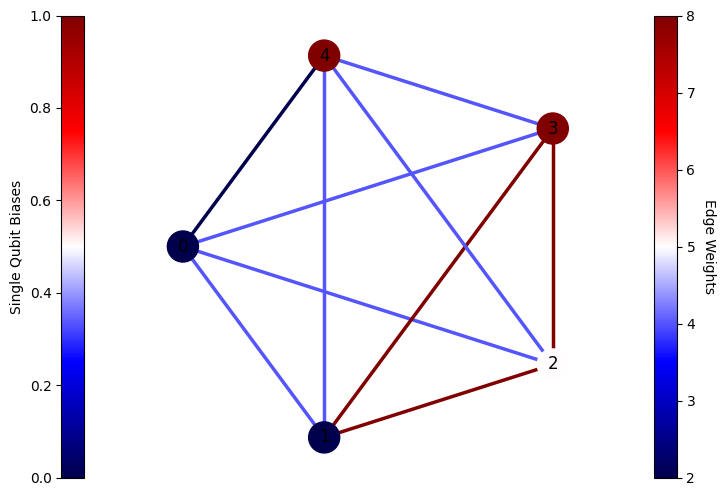

In [4]:
# visualize the QUBO form on a graph
from openqaoa.utilities import plot_graph, graph_from_hamiltonian

#extract Hamiltonain
cost_hamil = prob_qubo.hamiltonian

#convert Hamiltonian to graph
cost_gr = graph_from_hamiltonian(cost_hamil)

#plot the graph
plot_graph(cost_gr)

In [5]:
print(prob_qubo.asdict())

{'terms': [[0, 1], [2, 3], [2, 4], [3, 4], [0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4], [0], [1], [2], [3], [4]], 'weights': [4.0, 8.0, 4.0, 4.0, 4.0, 4.0, 2.0, 8.0, 8.0, 4.0, 0.0, 0.0, 0.5, 1.0, 1.0], 'constant': 11.5, 'n': 5, 'problem_instance': {'problem_type': 'knapsack', 'values': [1, 2, 2], 'weights': [2, 2, 1], 'weight_capacity': 4, 'penalty': 4, 'n_items': 3}, 'metadata': {}}


 Extract the exact solution



In [6]:
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian

energy, configuration = ground_state_hamiltonian(cost_hamil)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -4.0, Solution: ['10011']


## Step 2: Build the QAOA model on QPUs and cloud simulators

 - Initialize the model (with default parameters)
 - Optionally set the following properties for the model
     - `model.set_device(...)`: Set the device
         - The device properties include the location of the device `[local, qcs, ibmq]` and the device name. Full list of devices available at              `openqaoa.workflows.parameters.qaoa_parameters.ALLOWED_DEVICES`
     - `model.set_circuit_properties(...)`: Sets the circuit properties. Mainly used for:
         - `p`: the number of layers
         - `param_type`: the desired parameterisation to be chosen between `['standard', 'extended', 'fourier', annealing]`
         - `init_type`: the initialisation strategy for param_type. To be chosen between `['ramp', 'random', 'custom']`
     - `model.set_backend_properties(...)`
     - `model.set_classical_optimizer(...)`


    
For more details on the configurable properties, please refer to the documentation

## Demo for IBMQ cloud simulators and QPUs

In [7]:
qpu_credentials ={
    "hub": "ibm-q",
    "group": "open", 
    "project": "main"
}

To make our tests run, we load our own credentials through the test-credentials :) 

In [8]:
# import json
# import os
# credentials = open('../tests/credentials.json', 'r')

# with credentials as f:
#     json_obj = json.load(f)['QISKIT']
    
# qpu_credentials = {k.lower(): v for k, v in json_obj.items()}

hub,group and project can be specified during `save_account` or when `create_device` is called later. Note that if the values that are passed into `create_device` take precendent

In [9]:
# overwrite is optional. It ensures that only 1 account exists.
# This only needs to be done once in a session.
# IBMQ.save_account(token=qpu_credentials.pop('api_token'), overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
# initialize model with default configurations
q_qiskit = QAOA()

In [11]:
# device. If qpu_crendetials is not specified,the default hub, group and provider is used.
qiskit_cloud = create_device(location='ibmq', name='ibm_oslo', **qpu_credentials)
q_qiskit.set_device(qiskit_cloud)

# circuit properties
q_qiskit.set_circuit_properties(p=1, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_qiskit.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_qiskit.set_classical_optimizer(method='nelder-mead', maxiter=10, cost_progress=True,
                                 parameter_log=True, optimization_progress=True)

In [12]:
from openqaoa.algorithms.qaoa.qaoa_workflow import circuit_routing
q_qiskit.compile(prob_qubo, routing_function = circuit_routing)

Initial mapping {0: 0, 2: 1, 4: 2, 3: 3, 1: 4, 5: 5}
Final mapping [1, 4, 3, 0, 5, 2]
[[0], [1], [2], [3], [4], [0, 4], [1, 4], [3, 4], [2, 5], [3, 5], [3, 4], [0, 4], [1, 4], [3, 5], [0, 4], [1, 4], [3, 5], [3, 4], [1, 4], [3, 4]]


In [13]:
q_qiskit.backend.initial_qubit_mapping

[0, 1, 2, 3, 4, 5]

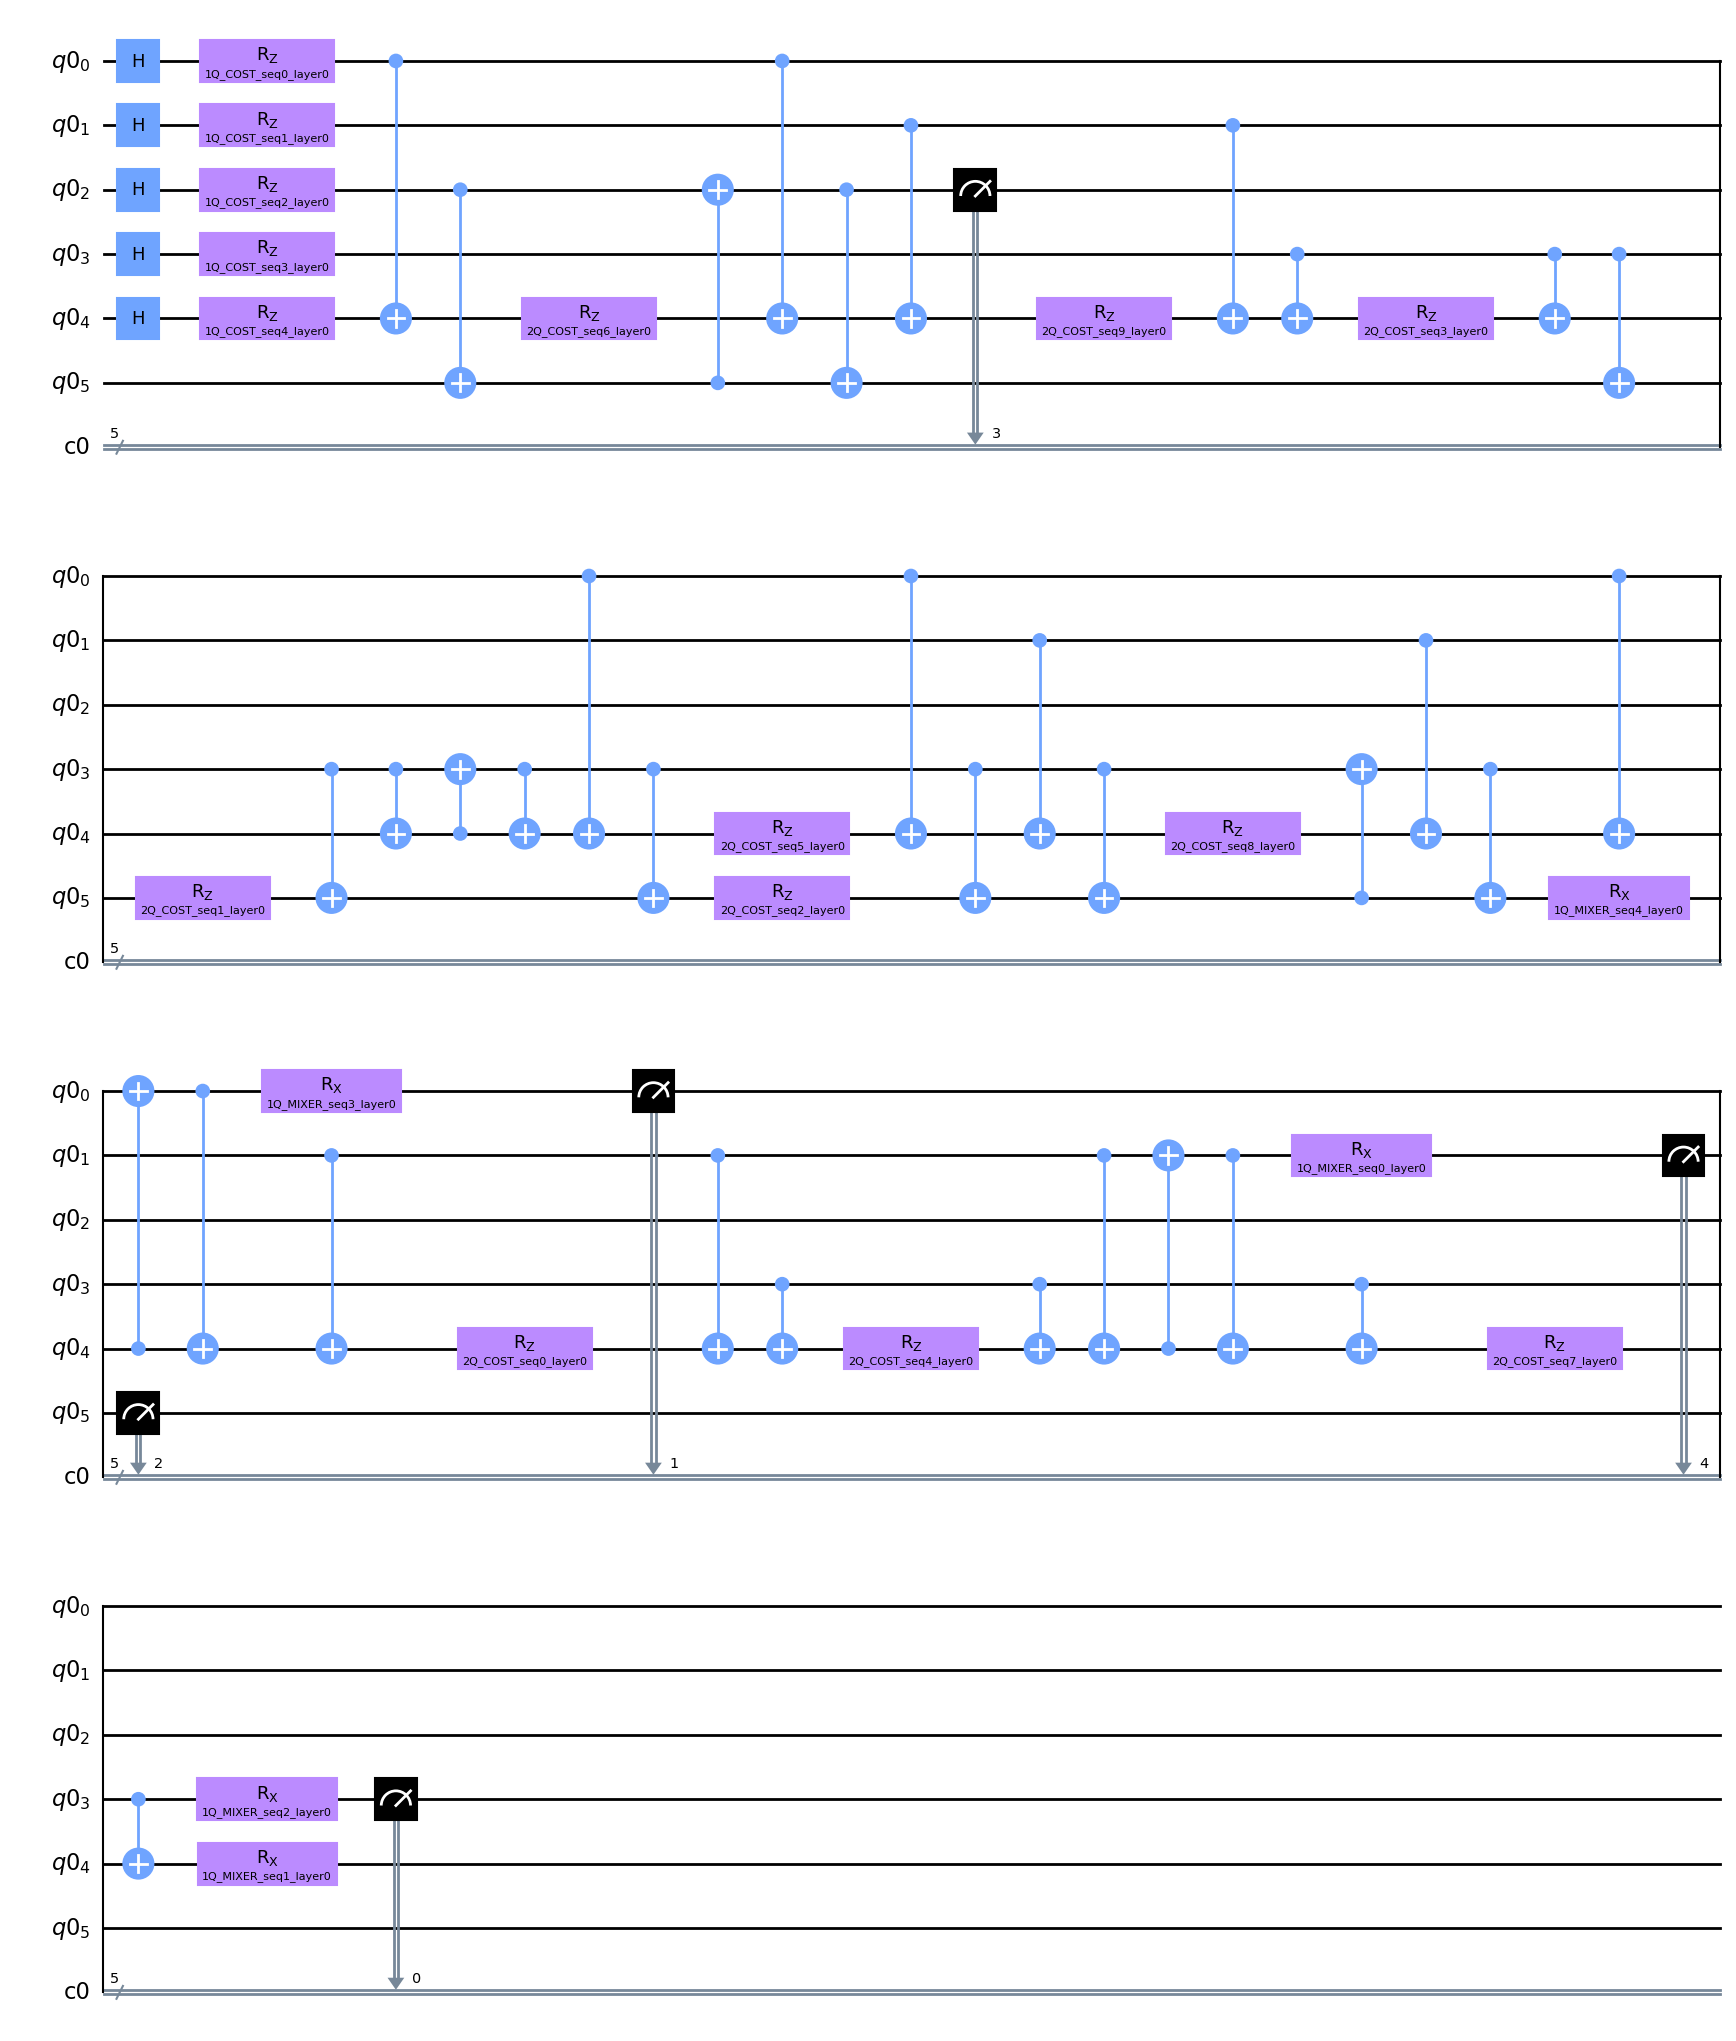

In [14]:
q_qiskit.backend.parametric_circuit.draw('mpl')
# q_qiskit.backend.qaoa_circuit(q_qiskit.variate_params).draw('mpl')

In [ ]:
q_qiskit.optimize()

ERROR -  - goodbye


## For Rigetti

In [9]:
rigetti_args ={
    'as_qvm':True, 
    'execution_timeout':10,
    'compiler_timeout':100
}

In [10]:
# initialize model with default configurations
q_pyquil = QAOA()

In [11]:
# device
# rigetti_device = create_device(location='qcs', name='Aspen-M-3', **rigetti_args)
rigetti_device = create_device(location='qcs', name='7q-qvm', **rigetti_args)

q_pyquil.set_device(rigetti_device)

# circuit properties
q_pyquil.set_circuit_properties(p=1, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_pyquil.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_pyquil.set_classical_optimizer(method='nelder-mead', maxiter=200, cost_progress=True,
                                 parameter_log=True, optimization_progress=True)

### Step 3: Compile and Optimize

- Once the QAOA model is configured, we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to create the underlying QAOA circuit.
- The problem is ready to be optimized now. The user can call `model.optimize()` to initiate the optimization loop. 

In [12]:
from openqaoa.algorithms.qaoa.qaoa_workflow import circuit_routing
q_pyquil.compile(prob_qubo,routing_function = circuit_routing)
# q_pyquil.compile(prob_qubo)

Initial mapping {0: 0, 4: 1, 3: 2, 5: 3, 2: 4}
Final mapping [0, 1, 2, 3, 4]
[[0], [1], [2], [3], [4], [0, 1], [1, 2], [0, 2], [1, 4], [0, 4], [1, 3], [0, 3], [2, 4], [2, 3], [3, 4]]


/home/vishal/repos/openqaoa/src/openqaoa-pyquil/backends/qaoa_pyquil_qpu.py:122: UserWarning: Ignoring the initial_qubit_mapping since the routing algorithm chose one
  warnings.warn("Ignoring the initial_qubit_mapping since the routing algorithm chose one")


In [13]:
print(q_pyquil.backend.qaoa_circuit(q_pyquil.variate_params))

DECLARE ro BIT[5]
DECLARE oneQ_COST_seq0_layer0 REAL[1]
DECLARE oneQ_COST_seq1_layer0 REAL[1]
DECLARE oneQ_COST_seq2_layer0 REAL[1]
DECLARE oneQ_COST_seq3_layer0 REAL[1]
DECLARE oneQ_COST_seq4_layer0 REAL[1]
DECLARE twoQ_COST_seq0_layer0 REAL[1]
DECLARE twoQ_COST_seq7_layer0 REAL[1]
DECLARE twoQ_COST_seq4_layer0 REAL[1]
DECLARE twoQ_COST_seq9_layer0 REAL[1]
DECLARE twoQ_COST_seq6_layer0 REAL[1]
DECLARE twoQ_COST_seq8_layer0 REAL[1]
DECLARE twoQ_COST_seq5_layer0 REAL[1]
DECLARE twoQ_COST_seq2_layer0 REAL[1]
DECLARE twoQ_COST_seq1_layer0 REAL[1]
DECLARE twoQ_COST_seq3_layer0 REAL[1]
DECLARE oneQ_MIXER_seq0_layer0 REAL[1]
DECLARE oneQ_MIXER_seq1_layer0 REAL[1]
DECLARE oneQ_MIXER_seq2_layer0 REAL[1]
DECLARE oneQ_MIXER_seq3_layer0 REAL[1]
DECLARE oneQ_MIXER_seq4_layer0 REAL[1]
RZ(pi) 2
RX(pi/2) 2
RZ(pi/2) 2
RX(-pi/2) 2
RZ(1.0*twoQ_COST_seq9_layer0[0] + 1.0*oneQ_COST_seq4_layer0[0]) 2
RX(pi/2) 2
RZ(pi/2) 2
RX(-pi/2) 2
RZ(pi) 0
RX(pi/2) 0
RZ(pi/2) 0
RX(-pi/2) 0
RZ(1.0*twoQ_COST_seq0_layer0[0]

In [14]:
q_pyquil.optimize()

## Step 4: Accessing the results

The process of obtaining the results for models with either device looks exactly the same. Therefore, to keep this notebook succinct, we only analyze results produced by one device.

In [15]:
opt_results = q_pyquil.results

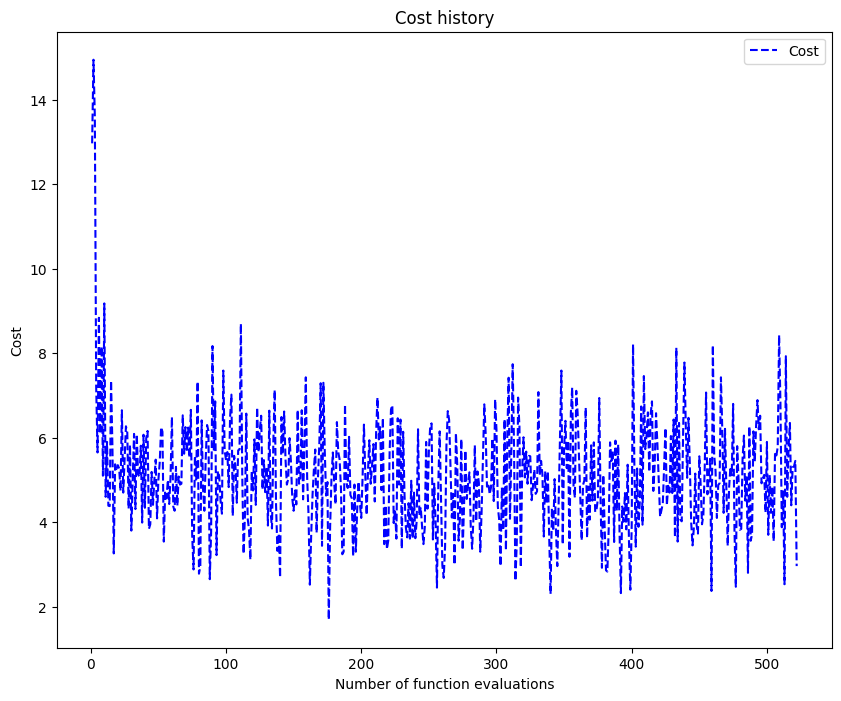

In [16]:
# print the cost history
opt_results.plot_cost()

In [20]:
# prints a large output (commented by default)
# pprint(opt_results.intermediate)

In [21]:
print(opt_results.optimized)

{'angles': [1.0697214021077555, 2.66020191842812, 1.008830150888525, 1.1339416740189403], 'cost': 145.87999999999994, 'measurement_outcomes': Counter({'00111000': 4, '11011001': 4, '10100010': 3, '00010011': 3, '11111000': 3, '10000011': 3, '01110011': 3, '10101101': 2, '11101010': 2, '01011101': 2, '10101001': 2, '10011100': 2, '01001010': 2, '00110111': 2, '01111010': 2, '00000111': 2, '00100110': 2, '01010110': 2, '00011111': 2, '10000110': 2, '00010101': 2, '01100100': 2, '10010111': 1, '01010010': 1, '10000101': 1, '01110000': 1, '00001001': 1, '10110111': 1, '10100001': 1, '10010011': 1, '01010111': 1, '00101100': 1, '01101000': 1, '11100000': 1, '01001100': 1, '00010110': 1, '10011010': 1, '11101100': 1, '01101001': 1, '00101010': 1, '01010101': 1, '11101011': 1, '01100011': 1, '01111000': 1, '10110011': 1, '11101101': 1, '01001000': 1, '00110101': 1, '10111001': 1, '10001010': 1, '10101000': 1, '01010100': 1, '11101000': 1, '10001101': 1, '10001001': 1, '10100100': 1, '11001000

In [22]:
opt_results.most_probable_states

{'solutions_bitstrings': ['00111000', '11011001'], 'bitstring_energy': 64.0}